# [Unitary Hack] Demonstrate Outperformance against the Default Optimizer

In [47]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.circuit.random import random_circuit
from qiskit_ionq import IonQProvider
from qiskit.transpiler import PassManager, PassManagerConfig
from qiskit.transpiler.preset_passmanagers.plugin import PassManagerStagePlugin
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.providers.fake_provider import GenericBackendV2

In [12]:
# Initialize the backends

api_key_ionq = os.getenv("IONQ_API_KEY") or input("Enter your IonQ API key: ")
provider_ionq = IonQProvider(token=api_key_ionq)
backend_ionq = provider_ionq.get_backend("simulator", gateset="native")

backend_qiskit = GenericBackendV2(16)

### Generate random circuits for benchmarking

In [59]:
number_of_circs = 10 # number of circuits required
level = 3 # optimization level
random_circs = [] # array to store the randomly generated circuits

for i in range(number_of_circs):
    random_circs.append(random_circuit(3, 3, measure=False))


### Transpile the circuits and Measure/Count the gates

In [60]:
#### Custom Optimizer

class TrappedIonOptimizerPlugin(PassManagerStagePlugin):
    def pass_manager(
        self,
        pass_manager_config: PassManagerConfig,
        optimization_level: int = 0,
    ) -> PassManager:
        custom_pm = PassManager()
        if optimization_level == 0:
            pass
        if optimization_level >= 1:
            custom_pm.append(FirstPass())
        return custom_pm


class FirstPass(TransformationPass):
    def run(self, dag):
        return dag


# Optimizer initialization
custom_pass_manager_plugin = TrappedIonOptimizerPlugin()
pass_manager_config = PassManagerConfig()

# Create a custom pass manager
custom_pass_manager = custom_pass_manager_plugin.pass_manager(
    pass_manager_config,
    optimization_level=3,
)

In [65]:
#### Transpile with Custom and Qiskit's default optimizer

transpiled_circs_custom, transpiled_circs_qiskit = [], []
depths_custom, depths_qiskit, gate_count_custom, gate_count_qiskit= [], [], [], []

for i in range(len(random_circs)):
    # Custom transpiled circuits
    o_qc_custom = custom_pass_manager.run(random_circs[i]) # optimized circuit
    t_qc_custom = transpile(o_qc_custom, backend=backend_ionq, optimization_level=level) # transpiled circuit
    
    transpiled_circs_custom.append(t_qc_custom)
    depths_custom.append(t_qc_custom.depth())
    gate_count_custom.append(sum(t_qc_custom.count_ops().values()))

    # Qiskit transpiler
    t_qc_qiskit = transpile(random_circs[i], backend=backend_qiskit, optimization_level=level)
    transpiled_circs_qiskit.append(t_qc_qiskit)

    transpiled_circs_qiskit.append(t_qc_qiskit)
    depths_qiskit.append(t_qc_qiskit.depth())
    gate_count_qiskit.append(sum(t_qc_qiskit.count_ops().values()))


#### Plotting and Analyzing

The circuit depth and number of gates for both the optimizers are plotted and analyzed to see which is better.

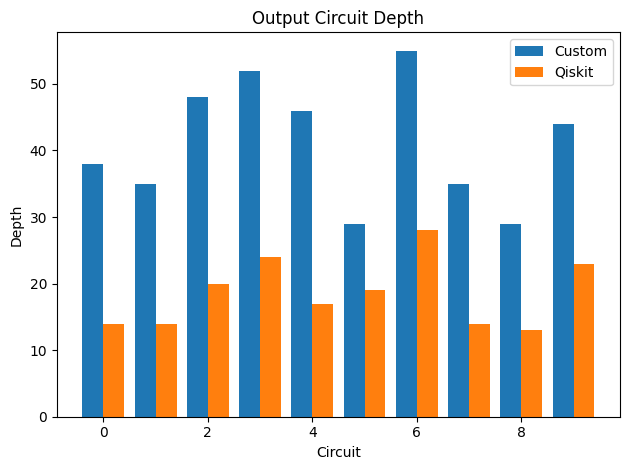

In [66]:
#### 'Output Circuit Depth' Plot

r = np.arange(number_of_circs)

plt.bar(r - 0.2, depths_custom, 0.4, label = 'Custom')
plt.bar(r + 0.2, depths_qiskit, 0.4, label='Qiskit')
plt.xlabel("Circuit")
plt.ylabel("Depth")
plt.title("Output Circuit Depth")
plt.legend()

plt.tight_layout()
plt.show()

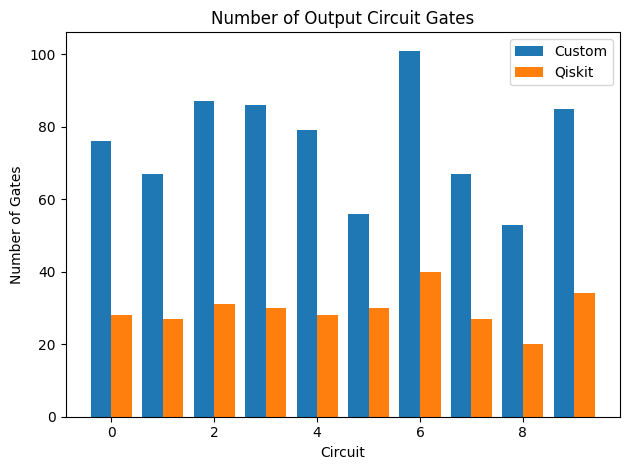

In [67]:
#### 'Number of output circuit gates' Plot

plt.bar(r - 0.2, gate_count_custom, 0.4, label = 'Custom')
plt.bar(r + 0.2, gate_count_qiskit, 0.4, label='Qiskit')
plt.xlabel("Circuit")
plt.ylabel("Number of Gates")
plt.title("Number of Output Circuit Gates")
plt.legend()

plt.tight_layout()
plt.show()

As can be seen in the above graphs, the 'custom' optimizer has a larger circuit depth and more number of gates compared to the 'qiskit' optimizer. This demonstrates the outperformance of the custom built optimizer over the default Qiskit optimizer.